<a href="https://colab.research.google.com/github/pg1992/IA025_2022S1/blob/main/ex04/pedro_moreira/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nome: 

In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from torchvision import transforms

from sklearn.datasets import load_iris
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_data = data[:,0:1]
target = data[:,1:2]
n_samples = x_data.shape[0]

print('dimensões de x_data:', x_data.shape)
print('dimensões de target:', target.shape)

dimensões de x_data: (50, 1)
dimensões de target: (50, 1)


In [ ]:
x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(target)
xt_min = x_train.min()
xt_max = x_train.max()
x_train_n = (x_train - xt_min)/(xt_max - xt_min)

yt_min = y_train.min()
yt_max = y_train.max()
y_train_n = (y_train - yt_min)/(yt_max - yt_min)

In [ ]:
x_train_bias = torch.cat([torch.ones(size=(n_samples,1)), x_train_n], dim=1)
print(x_train_bias.shape)

torch.Size([50, 2])


In [ ]:
dataset = TensorDataset(x_train_bias, y_train_n)

In [ ]:

data_loader = DataLoader(dataset, 
                         batch_size=10, # tamanho do mini-batch de dados
                         shuffle=True) # se for True, embaralha os dados no inicio de cada iteração

Solução ótima

In [ ]:
x_bias, y = next(iter(data_loader))

In [ ]:
w_opt = (torch.inverse(x_bias.t().mm(x_bias)).mm(x_bias.t())).mm(y)
print(w_opt.t(), w_opt.shape)

tensor([[0.3170, 0.5470]]) torch.Size([2, 1])


# Exercício é codificar a próxima célula:

In [ ]:
# colocar aqui um laço para 
# calcular os valores ótimos associados a cada batch
# é esperado um gráfico parecido com o gráfico

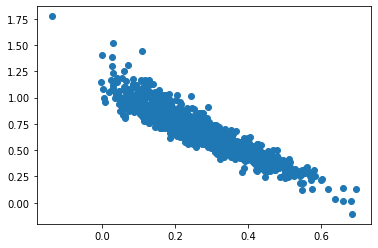

In [ ]:
#w_opt = torch.cat(wlist)
#plt.scatter(w_opt[:,0], w_opt[:,1])